<font color='purple'> **Проект: "Построение ML-продукта для решения задачи множественной классификации текстов."**</font>

- В нашем распоряжении ответы на опрос, состоящий из части с выбором ответа из списка и расширенного комментария с произвольным текстом.
- ***Цель:*** для каждого ответа из 50 различных меток классов выбрать все затронутые.

***План работы:***

  1) Предварительный осмотр данных: загрузка, краткий вывод, изменения типов данных (по необходимости)
  2) Разведовательный анализ данных.
  3) Анализ данных, выделение целевой переменной, отбор существующих и генерация новых признаков для итогового датасета.
  4) Валидация моделей.
  5) Тестирование лучшей модели на тестовом наборе.
  6) Общие выводы по проекту.

In [10]:
#%pip install dostoevsky

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, Text, word_tokenize, ngrams
from tqdm.auto import tqdm
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec
from wordcloud import WordCloud
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from nltk.metrics.distance import edit_distance, jaro_similarity, jaro_winkler_similarity
from difflib import SequenceMatcher
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import hamming_loss, f1_score
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance

In [12]:
sns.set_style('whitegrid')
sns.set_palette('pastel', n_colors=20)
plt.rcParams['lines.markersize'] = 15
plt.rcParams['font.size'] = 10 
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maiiayakusheva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maiiayakusheva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
random_state = 42

***1. Предварительный анализ данных:***

- сначала буду отдельно открывать таблицы с тренировочными данными и описанием таргетов и описывать их:

In [14]:
try:
    train = pd.read_csv('/nlp-user-experience-multilabel-classification/train.csv')
except:    
    train = pd.read_csv('/Users/maiiayakusheva/Downloads/nlp-user-experience-multilabel-classification'\
        '/train.csv')

In [15]:
def initial_analysis(df):
    print('Пример строки датасета:')
    display(df.sample(1))
    print('Общая информация о датасете:')
    print(df.info())
    print('Количество дубликатов:', df.duplicated().sum())
    print('Количество пропусков:')
    print(df.isna().sum()[df.isna().sum()!=0])

In [16]:
initial_analysis(train)

Пример строки датасета:


,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
8499,17521,5.0,"{PRODUCTS_QUALITY,DELIVERY}","Я уже почти перестала о вас думать, ибо сервис...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           8708 non-null   int64  
 1   assessment      8478 non-null   float64
 2   tags            8697 non-null   object 
 3   text            8708 non-null   object 
 4   trend_id_res0   8708 non-null   int64  
 5   trend_id_res1   8708 non-null   int64  
 6   trend_id_res2   8708 non-null   int64  
 7   trend_id_res3   8708 non-null   int64  
 8   trend_id_res4   8708 non-null   int64  
 9   trend_id_res5   8708 non-null   int64  
 10  trend_id_res6   8708 non-null   int64  
 11  trend_id_res7   8708 non-null   int64  
 12  trend_id_res8   8708 non-null   int64  
 13  trend_id_res9   8708 non-null   int64  
 14  trend_id_res10  8708 non-null   int64  
 15  trend_id_res11  8708 non-null   int64  
 16  trend_id_res12  8708 non-null   int64  
 17  tren

- открыт датасет с тренировочными данными, содержащий 54 столбца (2 из которых имеют строковый тип данных и 52 численный) и 8708 строк записей. В датасете присутствуют пропуски в столбцах "оценка"(230) и "теги"(11), в связи с их крайне малым количеством целесообразно будет их удалить. Дубликаты в датасете отсуствуют. Так как данная задача является задачей множественной классификации в этом датасете присутствует массив таргетов(в количестве 50 столбцов)

In [17]:
#предобработка
train = train.fillna('0')
#train.reset_index(drop=True, inplace=True)
train.shape

(8708, 54)

In [18]:
try:
    trends = pd.read_csv('/nlp-user-experience-multilabel-classification/trends_description.csv',\
         index_col=[0])
except:    
    trends = pd.read_csv('/Users/maiiayakusheva/Downloads/nlp-user-experience-multilabel-classification/'\
    'trends_description.csv', index_col=[0])

In [19]:
initial_analysis(trends)

Пример строки датасета:


,trend,explanation
trend_id,,
3,Регулярные опоздания,"- клиент акцентриет внимание, что мы часто/каж..."


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   trend        50 non-null     object
 1   explanation  50 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None
Количество дубликатов: 0
Количество пропусков:
Series([], dtype: int64)


- открыт датасет с расшифровкой меток классов (таргетов), содержащий 3 столбца и 50 строк с данными (1 столбец имеет численный тип данных и два строковый). Пропусков и дубликатов в таблице нет.

***2. Разведовательный анализ данных***

- здесь сначала посмотрю на распределения некоторых признаков и таргетов, возможно сделаю некоторую предобработку и выведу дополнительные признаки
- затем займусь анализом и предобработкой текстов

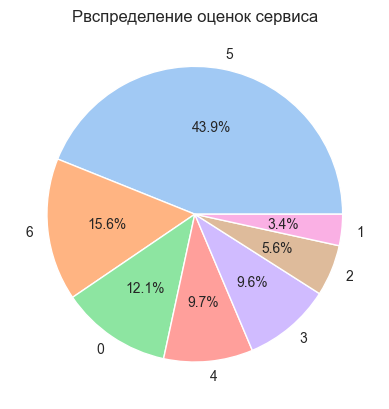

In [20]:
#предобработка
train.assessment = train.assessment.astype(int)
train.assessment.value_counts().plot(kind='pie', autopct='%1.1f%%', title='Рвспределение оценок сервиса',\
    ylabel='');

- столбец "assessment" несет в себе информацию об оценках сервиса пользователями. По информации от заказчика тут нет самых высоких оченок (шкала о  1 до 10), соотвественно высшей оценкой является значение 6. По распределению видно, что практически половину(45.2%) от всех оценок занимает значение 5
- далее из столбца с тегами, который несет информацию о том, чем именно в сервисе недоволен потребитель, я выделю бинарные столбцы (8 шт) для каждого тега и проставлю в них единицы там, где этот тег соотвественно упоминается (это пригодится для анализа, а возможно и как признаки для финального датасета). Затем посмотрим на общее распределение этих данных.

In [21]:
#предобработка
tags_list = np.unique(pd.Series([re.sub('[{}]', '', x) for x in train.tags])\
    .str.split(',', expand=True).dropna().values).tolist()
def tags(name):
    train[name.lower()]=pd.Series(np.where(train.tags.str.contains(pat=name)==True, 1, 0))
for x in tags_list:
    tags(x)

In [22]:
def binar_col_analys(df):
    idx=[]
    cols = {'1': [], '0': []}
    for x in df:
        idx += [x]
        cols['1'].append(int(df[x].value_counts()[df[x].value_counts().index==1].median()))
        cols['0'].append(int(df[x].value_counts()[df[x].value_counts().index==0].median()))
        df_counts = pd.DataFrame(cols, index=idx)
    
    return df_counts

In [23]:
num_bin_cols = ['price', 'payment', 'support', 'delivery', 'assortment', 'promotions', 'products_quality', 
       'catalog_navigation']

In [24]:
binar_col_analys(train[num_bin_cols])

,1,0
price,3937,4771
payment,970,7738
support,1808,6900
delivery,4693,4015
assortment,4555,4153
promotions,4894,3814
products_quality,2561,6147
catalog_navigation,1203,7505


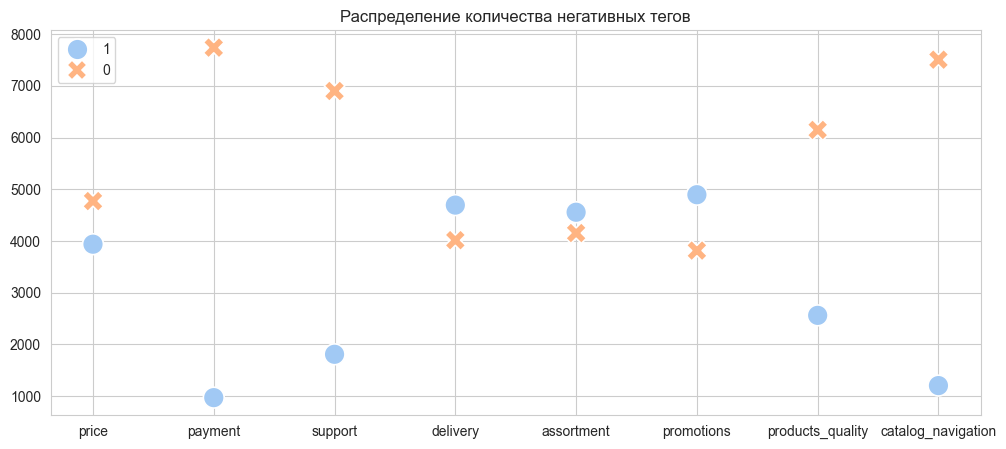

In [25]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=binar_col_analys(train[num_bin_cols]))\
              .set_title('Распределение количества негативных тегов');

- на визуализации наиболее понятно показано соотношение присутствия и отсутствия негативных тегов в ответах пользователей:
  - например меньше всего недовольства вызывает система платежей и навигация по катологу, а вот больше всего - доставка, выбор продукции и промоушн (это три тега где количество наличия недовольных тегов превышает количество их отсутствия)
- далее посмотрю на распределения тегов при низшей и высшей оценке потребителя:

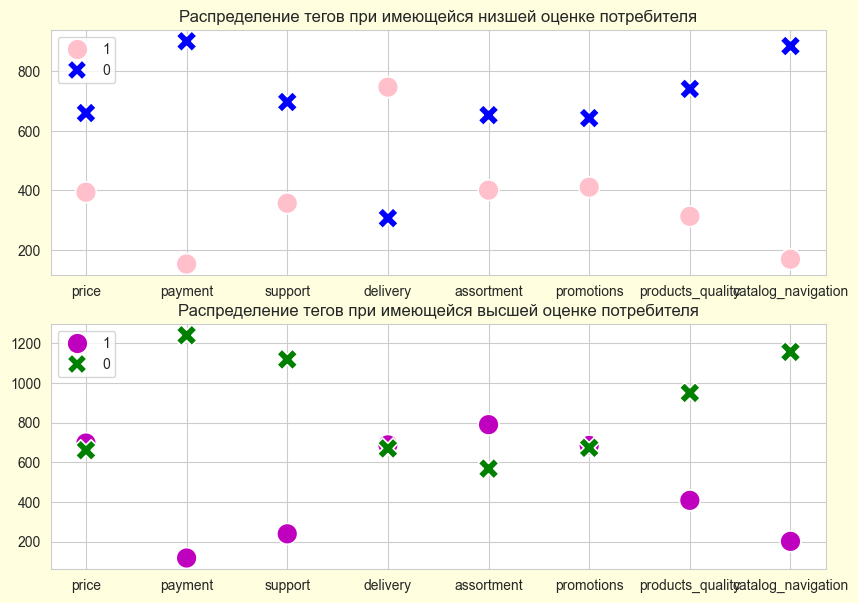

In [26]:
fig, axs = plt.subplots(figsize=(10, 7), facecolor='lightyellow', nrows=2)
plt.rcParams['lines.markersize'] = 15
sns.scatterplot(data=binar_col_analys(train[num_bin_cols][train.assessment==0]),\
     ax=axs[0], palette=["pink", "b"]).set_title('Распределение тегов при имеющейся низшей оценке потребителя')
sns.scatterplot(data=binar_col_analys(train[num_bin_cols][train.assessment==6]),\
     ax=axs[1], palette=["m", "g"]).set_title('Распределение тегов при имеющейся высшей оценке потребителя');

- можно заметить, что пользователи, поставившие низшую оценку (0), более всего недовольны доставкой, в то время как пользователи с наивысшей из имеющихся оценкой - ассортиментом продукции
- теперь посмотрю на распределение таргетов (для конкретизации значений временно соединю их с данными из таблицы с расшифровкой информации о трендах):

In [27]:
targets = ['trend_id_res0', 'trend_id_res1',
           'trend_id_res2', 'trend_id_res3', 'trend_id_res4', 'trend_id_res5',
           'trend_id_res6', 'trend_id_res7', 'trend_id_res8', 'trend_id_res9',
           'trend_id_res10', 'trend_id_res11', 'trend_id_res12', 'trend_id_res13',
           'trend_id_res14', 'trend_id_res15', 'trend_id_res16', 'trend_id_res17',
           'trend_id_res18', 'trend_id_res19', 'trend_id_res20', 'trend_id_res21',
           'trend_id_res22', 'trend_id_res23', 'trend_id_res24', 'trend_id_res25',
           'trend_id_res26', 'trend_id_res27', 'trend_id_res28', 'trend_id_res29',
           'trend_id_res30', 'trend_id_res31', 'trend_id_res32', 'trend_id_res33',
           'trend_id_res34', 'trend_id_res35', 'trend_id_res36', 'trend_id_res37',
           'trend_id_res38', 'trend_id_res39', 'trend_id_res40', 'trend_id_res41',
           'trend_id_res42', 'trend_id_res43', 'trend_id_res44', 'trend_id_res45',
           'trend_id_res46', 'trend_id_res47', 'trend_id_res48', 'trend_id_res49']

In [28]:
targets_df = pd.concat([binar_col_analys(train[targets]).reset_index(drop=True), pd.DataFrame(trends.trend)],\
     axis=1)
targets_df.sort_values(by='1', ascending=False)

,1,0,trend
0,837,7871,Долгая доставка
12,624,8084,Высокие цены
2,597,8111,Время доставки не соответствует заявленому
27,530,8178,Качество товаров
28,420,8288,Маленький ассортимент
3,361,8347,Регулярные опоздания
19,360,8348,Нет смысла
1,347,8361,Доставка стала долгой
30,306,8402,Качество поддержки
18,231,8477,Спасибо


- по распределению таргетов видим, что наибольшее количество положительного класса присутствует у значений: "Долгая доставка",  "Высокие цены", "Несоотвествие времени доставки"

***3. Анализ и обработка текстов:***

- сначала я для визуализации я построю облако слов, оно отобразит какие слова чаще всего встречаются в первых шести комментариях под теми или иными тегами

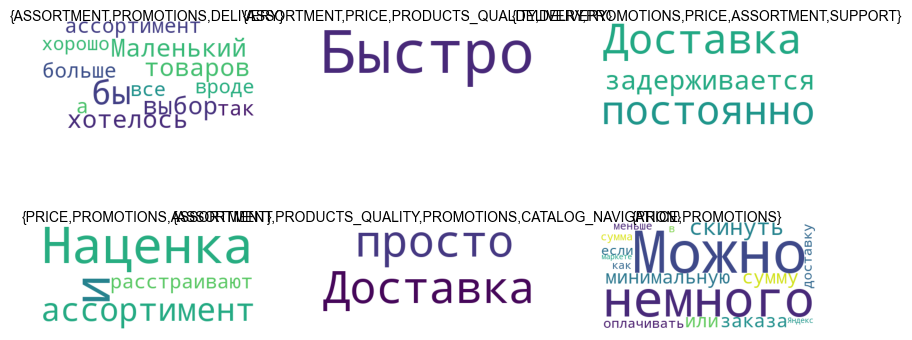

In [29]:
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.3, hspace=0.2)
i = 1
for name, text in zip(train.tags[:6], train.text[:6]):
    tokens = word_tokenize(text)
    text_raw = " ".join(tokens)
    wordcloud = WordCloud(colormap='viridis', background_color='white', contour_width=10)\
        .generate(text_raw)
    plt.subplot(4, 3, i, label=name,frame_on=True)
    plt.tick_params(labelsize=10)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(name,fontdict={'fontsize':10,'color':'black'},y=0.93)
    plt.tick_params(labelsize=10)
    i += 1

In [30]:
FreqDist(Text(train.text)).most_common(10)

[('👍', 46),
 ('.', 46),
 ('Долгая доставка', 45),
 ('Все хорошо', 40),
 ('Все отлично', 39),
 ('Супер', 36),
 ('Все супер', 34),
 ('Очень долгая доставка', 33),
 ('Молодцы', 31),
 ('Норм', 30)]

In [31]:
FreqDist(Text(train[train.assessment==0].text)).most_common(10)

[('Долго', 10),
 ('Долгая доставка', 7),
 ('Очень долгая доставка', 6),
 ('.', 6),
 ('Все плохо', 5),
 ('…', 3),
 ('Очень долго', 3),
 ('Ничего хорошего', 3),
 ('Отвратительный сервис', 3),
 ('[NUM]', 3)]

In [32]:
FreqDist(Text(train[train.assessment==5].text)).most_common(10)

[('👍', 40),
 ('Все отлично', 35),
 ('Все хорошо', 35),
 ('Супер', 33),
 ('Все супер', 31),
 ('Молодцы', 29),
 ('Все нравится', 22),
 ('Вы супер', 20),
 ('Все ок', 17),
 ('Спасибо', 17)]

In [33]:
FreqDist(Text(train[train.assessment==6].text)).most_common(10)

[('.', 13),
 ('Норм', 11),
 ('Долгая доставка', 6),
 ('Привет', 5),
 ('Дорого', 5),
 ('норм', 5),
 ('Быстро', 4),
 ('Нормально', 4),
 ('Ок', 3),
 ('Пойдет', 3)]

- тут я вывела по 10 наиболее часто встречающихся комментариев во всем датасете/строках с низшей и строках с вышей оценками, видно что комментарии оченкам соотвествуют, а в общем датасете большинство занимют положительные комментарии и жалобы на доставку
- затем при помощи библиотеки dostoevsky я проанализирую семантику комментариев и создам три столбца с сентиментарными характеристиками комментариев (позитивные/негативные/нейтральные)

In [34]:
#предобработка
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [35]:
#предобработка
res = model.predict(train.text.tolist(), k=2)
sentiment_list = []
for sentiment in res:
    sentiment_list.append(sentiment)

In [36]:
#предобработка
neutral_list = []
negative_list = []
positive_list = []
speech_list = []
skip_list = []
for sentiment in sentiment_list:
    neutral = sentiment.get('neutral')
    negative = sentiment.get('negative')
    positive = sentiment.get('positive')
    if neutral is None:
        neutral_list.append(0)
    else:
        neutral_list.append(sentiment.get('neutral'))
    if negative is None:
        negative_list.append(0)
    else:
        negative_list.append(sentiment.get('negative'))
    if positive is None:
        positive_list.append(0)
    else:
        positive_list.append(sentiment.get('positive'))
train['neutral'] = neutral_list
train['negative'] = negative_list
train['positive'] = positive_list

In [37]:
train[train.positive >0.9].text.head()

8          Все отлично
15         Вы классные
17    Отличный сервис!
39             Молодцы
48         я вас люблю
Name: text, dtype: object

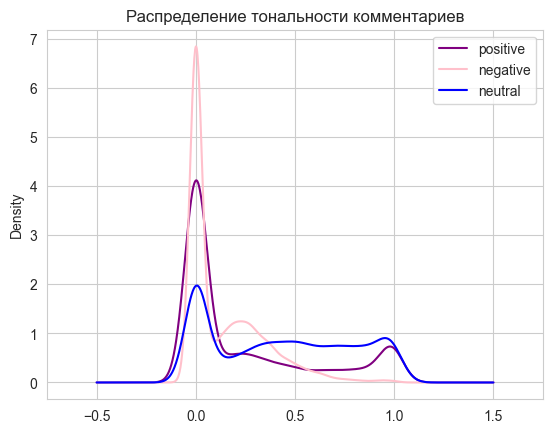

In [38]:
ax=train.positive.plot(kind='density', color='purple', legend=True)
train.negative.plot(kind='density', ax=ax, color='pink', legend=True)
train.neutral.plot(kind='density', ax=ax, color='blue', legend=True)
ax.set_xlim(-0.75, 1.75)
ax.set_title('Распределение тональности комментариев');

- далее я сначала проведу предобработку текстов: приведу в нижний регистр, уберу знаки пунктуации, символы,стоп-слова, токенизирую и лематизирую текст.

In [39]:
#предобработка
stopword = stopwords.words("russian")
def preprocess_text(text):
    sub_text = [x.lower() for x in text]
    sub_text_ = [re.sub('[^\w\s]', '', x) for x in sub_text]
    tokens = [nltk.word_tokenize(x) for x in sub_text_]
    lemms =  [[nltk.WordNetLemmatizer().lemmatize(y, pos='v') for y in x]for x in tokens]
    clear = [[x.strip() for x in y if x not in stopword] for y in lemms]
    text = [' '.join(z) for z in clear]
    return text
train['prepr_text'] = preprocess_text(train.text)

- Теперь посмотрю на средние/максимальные/минимальные(для расстояния) метрики близости (расстояние Левинштейна,Джаро) комментариев и тегов, переведенных на русский(не стала подтягивать переводчик, их всего восемь штук))
- сразу создам на этих метриках доп признаки, потом посмотрю какой они дадут результат на валидации

In [40]:
#предобработка
def sim_metrics(metric, vars, word):
    list_ = []
    for x in vars:
        list_.append(metric(x, word))
    return list_

In [41]:
#предобработка
tags_rus = ['ассортимент', 'каталог', 'доставка', 'платеж', 'цена', 'качество', 'акции', 'поддержка']

In [42]:
#предобработка
for x in tags_rus:
    lev_dis = []
    lev_dis.append(sim_metrics(edit_distance, train.prepr_text, x))
    print(f'Среднее расстояние Левинштейна для {x}',\
         round(np.mean(sim_metrics(edit_distance, train.prepr_text, x)), 2), '||',\
            f'миниммальное расстояние Левинштейна для {x}',\
                np.min(sim_metrics(edit_distance, train.prepr_text, x)))

Среднее расстояние Левинштейна для ассортимент 52.62 || миниммальное расстояние Левинштейна для ассортимент 0
Среднее расстояние Левинштейна для каталог 53.9 || миниммальное расстояние Левинштейна для каталог 4
Среднее расстояние Левинштейна для доставка 52.79 || миниммальное расстояние Левинштейна для доставка 0
Среднее расстояние Левинштейна для платеж 54.31 || миниммальное расстояние Левинштейна для платеж 3
Среднее расстояние Левинштейна для цена 55.1 || миниммальное расстояние Левинштейна для цена 1
Среднее расстояние Левинштейна для качество 53.32 || миниммальное расстояние Левинштейна для качество 4
Среднее расстояние Левинштейна для акции 54.98 || миниммальное расстояние Левинштейна для акции 3
Среднее расстояние Левинштейна для поддержка 53.58 || миниммальное расстояние Левинштейна для поддержка 3


In [43]:
for x in tags_rus:
    jaro_sim = []
    jaro_sim.append(sim_metrics(jaro_winkler_similarity, train.prepr_text, x))
    print(f'Среднее jaro_winkler_similarity для {x}',\
         round(np.mean(sim_metrics(jaro_winkler_similarity, train.prepr_text, x)), 2), '||',\
            f'максимальное jaro_winkler_similarity для {x}',\
                round(np.max(sim_metrics(jaro_winkler_similarity, train.prepr_text, x)), 2))

Среднее jaro_winkler_similarity для ассортимент 0.5 || максимальное jaro_winkler_similarity для ассортимент 1.0
Среднее jaro_winkler_similarity для каталог 0.45 || максимальное jaro_winkler_similarity для каталог 0.81
Среднее jaro_winkler_similarity для доставка 0.5 || максимальное jaro_winkler_similarity для доставка 1.0
Среднее jaro_winkler_similarity для платеж 0.45 || максимальное jaro_winkler_similarity для платеж 0.78
Среднее jaro_winkler_similarity для цена 0.43 || максимальное jaro_winkler_similarity для цена 0.88
Среднее jaro_winkler_similarity для качество 0.48 || максимальное jaro_winkler_similarity для качество 0.88
Среднее jaro_winkler_similarity для акции 0.4 || максимальное jaro_winkler_similarity для акции 0.82
Среднее jaro_winkler_similarity для поддержка 0.46 || максимальное jaro_winkler_similarity для поддержка 0.94


In [44]:
#предобработка
train['lev_dis'] = np.array(lev_dis).reshape(-1).tolist()
train['jaro_sim'] = np.array(jaro_sim).reshape(-1).tolist()

- далее я хочу попробовать создать вектора из текстового столбца пользуясь:
  - простым словарем индексов
  - Count/TfidfVectorizer
  - моделью Word2Vec/Fasttext
- проверять качество полученных векторов буду используя целевую метрику accuracy
- еще хочу посмотреть на результаты регрессии/мультиклассовой классификации векторов к оценке пользователя (столбец - assessment)
- также попробую снизить размерность полученных векторов и также посмотрю на качество классификации

In [45]:
def vectorize(text):
    splitted_text = [x.split() for x in text]
    words = Counter()
    for sentence in tqdm(splitted_text):
        for word in sentence:
            words[word] += 1
    vocab = set()
    for word, count in words.items():
        if word not in vocab:
            vocab.add(word)
    word2ind = {char: i for i, char in enumerate(vocab)}
    ind2word = {i: char for char, i in word2ind.items()}
    vectorized_text = [[word2ind.get(x) for x in y] for y in splitted_text]
    norm_vectors = [[round((x-np.mean(y))/np.std(y), 2) if len(y)>1 else .0 for x in y]\
         for y in vectorized_text]
    return norm_vectors

In [46]:
vect_text = vectorize(train.prepr_text)
vect_text = pd.DataFrame(vect_text).fillna(0)

  0%|          | 0/8708 [00:00<?, ?it/s]

In [47]:
y = np.asarray(train[targets])
text_train, text_test, y_train, y_test = train_test_split(vect_text, y,\
     test_size=0.2, random_state=random_state)

In [48]:
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',\
     hamming_loss(y_test, clf.predict(text_test)))

accuracy: 0.4552238805970149 hamming_loss: 0.0160849598163031


In [49]:
lgbm_reg = LGBMRegressor(random_state=random_state, n_jobs=-1, verbose=0)
lgbm_reg.fit(vect_text, train.assessment)
mean_absolute_error(train.assessment, lgbm_reg.predict(vect_text))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


1.2970665110513808

In [50]:
lgbm_clf = LGBMClassifier(random_state=random_state, verbose=0)
lgbm_clf.fit(vect_text, train.assessment)
f1_score(train.assessment, lgbm_clf.predict(vect_text), average='micro')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


0.7355305466237942

- итого на векторах из словаря индексов:
  - целевая метрика - 0.47, функция потерь Хэмминга - 0.016
- теперь сначала определю количество кластеров методом локтя, потом уменьшу размерность и посмотрю на результат

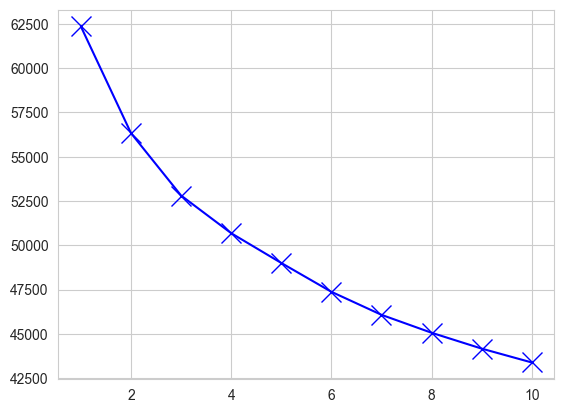

In [51]:
dis = []
K = range(1, 11)
for k in K:
    m = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    m.fit(vect_text.values)
    dis.append(m.inertia_)
plt.plot(K, dis, 'bx-');

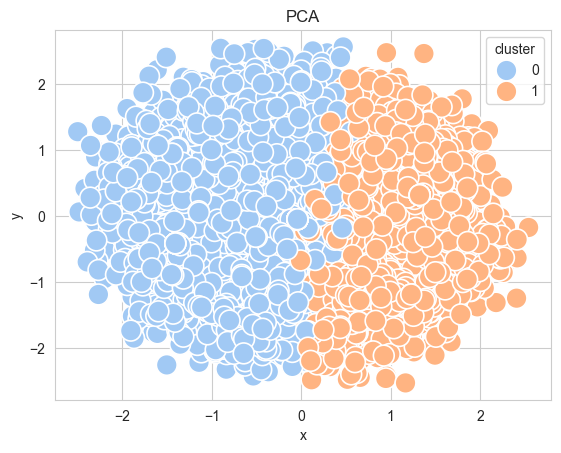

In [52]:
km_cluster = KMeans(n_clusters=2, random_state=random_state, n_init=10).fit_predict(vect_text.values)
pca2D = PCA(n_components=2)
pca_2D = pca2D.fit_transform(vect_text.values)
pca2D_df = pd.DataFrame(data = pca_2D, columns = ['x', 'y'])

pca2D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca2D_df)
plt.title("PCA")
plt.show()

In [53]:
text_train, text_test, y_train, y_test = train_test_split(pca2D_df.drop('cluster', axis=1), y,\
     test_size=0.2, random_state=random_state)

In [54]:
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.4563719862227325 hamming_loss: 0.01602755453501722


- итого видим, что при снижении размерности более, чем в 15 раз результат не поменялся
- теперь сделаю вектора при помощи CountVectorizer и TfidfVectorizer

In [55]:
count_vectorizer = CountVectorizer(ngram_range=(1,6), max_features=100)
count_vectors_df = pd.DataFrame(count_vectorizer.fit_transform(train.prepr_text).toarray())
text_train, text_test, y_train, y_test = train_test_split(count_vectors_df, y,\
     test_size=0.2, random_state=random_state)
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.4707233065442021 hamming_loss: 0.015017221584385763


In [56]:
lgbm_reg = LGBMRegressor(random_state=random_state, n_jobs=-1, verbose=0)
lgbm_reg.fit(count_vectors_df, train.assessment)
mean_absolute_error(train.assessment, lgbm_reg.predict(count_vectors_df))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


1.3332562428207642

In [57]:
lgbm_clf = LGBMClassifier(random_state=random_state, verbose=0)
lgbm_clf.fit(count_vectors_df, train.assessment)
f1_score(train.assessment, lgbm_clf.predict(count_vectors_df), average='micro')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


0.5791226458429031

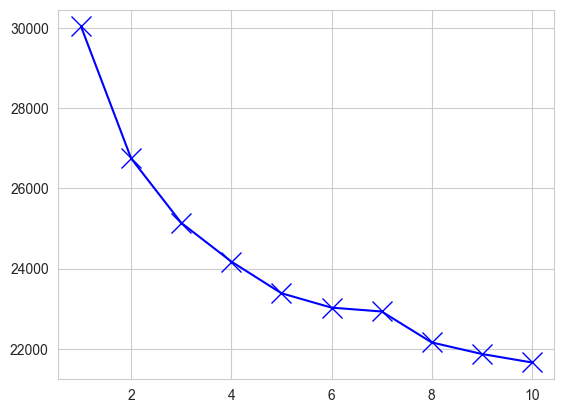

In [58]:
dis = []
K = range(1, 11)
for k in K:
    m = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    m.fit(count_vectors_df.values)
    dis.append(m.inertia_)
plt.plot(K, dis, 'bx-');

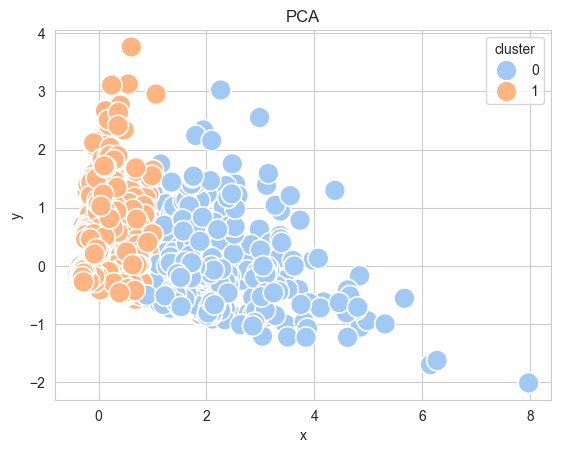

In [59]:
km_cluster = KMeans(n_clusters=2, random_state=random_state, n_init=10).fit_predict(count_vectors_df.values)
pca2D = PCA(n_components=2)
pca_2D = pca2D.fit_transform(count_vectors_df.values)
pca2D_df = pd.DataFrame(data = pca_2D, columns = ['x', 'y'])

pca2D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca2D_df)
plt.title("PCA")
plt.show()

In [60]:
text_train, text_test, y_train, y_test = train_test_split(pca2D_df, y,\
     test_size=0.2, random_state=random_state)
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.45464982778415614 hamming_loss: 0.015981630309988518


In [61]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,6), max_features=100)
tfidf_vectors_df = pd.DataFrame(tfidf_vectorizer.fit_transform(train.prepr_text).toarray())
text_train, text_test, y_train, y_test = train_test_split(tfidf_vectors_df, y,\
     test_size=0.2, random_state=random_state)
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.47416762342135477 hamming_loss: 0.014936854190585535


In [62]:
lgbm_reg = LGBMRegressor(random_state=random_state, n_jobs=-1, verbose=0)
lgbm_reg.fit(tfidf_vectors_df, train.assessment)
mean_absolute_error(train.assessment, lgbm_reg.predict(tfidf_vectors_df))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


1.2731109669335134

In [63]:
lgbm_clf = LGBMClassifier(random_state=random_state, verbose=0)
lgbm_clf.fit(tfidf_vectors_df, train.assessment)
f1_score(train.assessment, lgbm_clf.predict(tfidf_vectors_df), average='micro')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


0.670303169499311

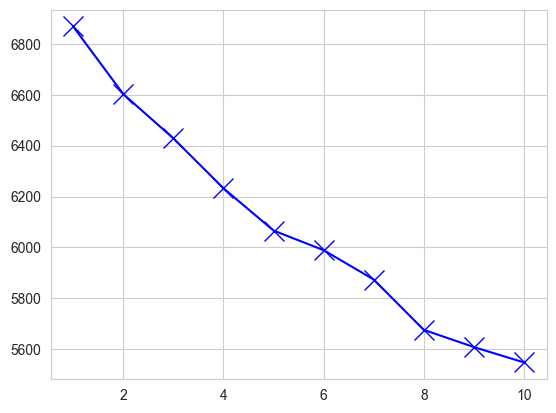

In [64]:
dis = []
K = range(1, 11)
for k in K:
    m = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    m.fit(tfidf_vectors_df.values)
    dis.append(m.inertia_)
plt.plot(K, dis, 'bx-');

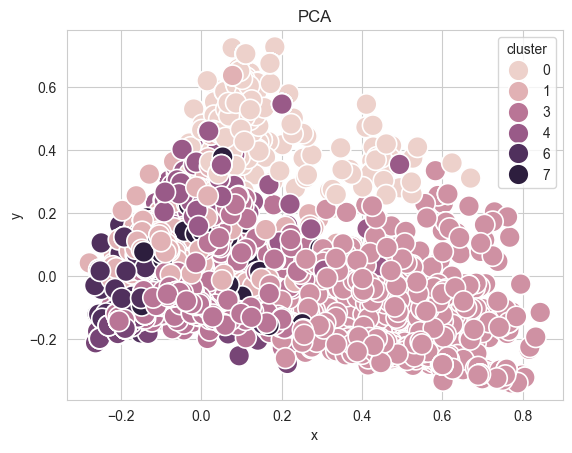

In [65]:
km_cluster = KMeans(n_clusters=8, random_state=random_state, n_init=10).fit_predict(tfidf_vectors_df.values)
pca8D = PCA(n_components=8)
pca_8D = pca8D.fit_transform(tfidf_vectors_df.values)
pca8D_df = pd.DataFrame(data = pca_8D, columns = ['x', 'y', 'z', 'i', 'j', 'm', 'n', 'l'])

pca8D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca8D_df)
plt.title("PCA")
plt.show()

In [66]:
text_train, text_test, y_train, y_test = train_test_split(pca8D_df, y,\
     test_size=0.2, random_state=random_state)
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.4764638346727899 hamming_loss: 0.015327210103329506


- видим, что лучшая метрика у TfidfVectorizer-векторов (0.48), а снижение размерности даже немного ее улучшило
- теперь создам вектора при помощи модели word2vec

In [67]:
splitted_text = [x.split(',') for x in train.prepr_text]
mod_w2v = word2vec.Word2Vec(splitted_text, window=3, min_count=2, seed=random_state, workers=2)
vectorized_text = [[mod_w2v.wv.key_to_index.get(x) for x in y] for y in splitted_text]
w2v_df = pd.DataFrame(vectorized_text).fillna(0)

In [68]:
text_train, text_test, y_train, y_test = train_test_split(w2v_df, y,\
     test_size=0.2, random_state=random_state)
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.4563719862227325 hamming_loss: 0.01602755453501722


- видим, что лучшую метрику дали вектора tfidf
- введу признак с длиной каждого комментария
- также переведу теги на русский, сделаю это через регулярки, так как эта манипуляция через например айпи гугл транса занимает более получаса) Затем добавлю переведенные теги к нашим текстам, посмотрю на целевую метрику, получу метрики для предсказания оценок и попробую снизить размерность

In [69]:
#предобработка
uniq = []
for text in train.prepr_text:
    uniq.append(len(set(text.split())))
train['uniq_words'] = uniq

In [70]:
#предобработка
train['tags'] = [re.sub('[{}]', '', x) for x in train.tags.str.lower()]
train['tags'] = [re.sub(',', ', ', x) for x in train.tags]

In [71]:
#предобработка
def elem_func(w1, w2):
    l = [re.sub(w1, w2, x) for x in train.tags]
    return l

In [74]:
def new_train_col(tag1, tag2):
    train['tags'] = elem_func(tag1, tag2)
new_train_col('assortment', 'ассортимент')
new_train_col('promotions', 'акции')
new_train_col('delivery', 'доставка')
new_train_col('price', 'цена')
new_train_col('products_quality', 'качество')
new_train_col('catalog_navigation', 'каталог')
new_train_col('payment', 'платеж')
new_train_col('support', 'поддержка')

- теперь соединю вместе столбцы с комментариями и тегами и просмотрю на получившийся результат

In [76]:
#предобработка
all_text = train[['prepr_text', 'tags']].agg(', '. join , axis= 1)

In [77]:
#предобработка
y = np.asarray(train[targets])
tfidf_vectors_all_df = pd.DataFrame(tfidf_vectorizer.fit_transform(all_text).toarray())
text_train, text_test, y_train, y_test = train_test_split(tfidf_vectors_all_df, y,\
     test_size=0.2, random_state=random_state)
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.48163030998851897 hamming_loss: 0.015005740528128588


In [78]:
#предобработка
lgbm_reg = LGBMRegressor(random_state=random_state, verbose=0)
lgbm_reg.fit(tfidf_vectors_all_df, train.assessment)
reg_preds = lgbm_reg.predict(tfidf_vectors_all_df)
train['reg_preds'] = reg_preds
mean_absolute_error(train.assessment, reg_preds)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


1.1576798344112356

In [79]:
#предобработка
lgbm_clf = LGBMClassifier(random_state=random_state, verbose=0)
lgbm_clf.fit(tfidf_vectors_all_df, train.assessment)
clf_preds = lgbm_clf.predict(tfidf_vectors_all_df)
train['clf_preds'] = clf_preds
f1_score(train.assessment, clf_preds, average='micro')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


0.7473587505741847

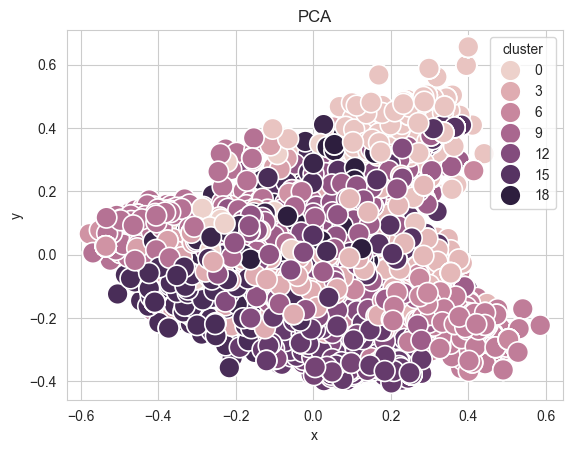

In [80]:
km_cluster = KMeans(n_clusters=19, random_state=random_state, n_init=10).fit_predict(tfidf_vectors_all_df.values)
pca19D = PCA(n_components=19, random_state=random_state)
pca_19D = pca19D.fit_transform(tfidf_vectors_all_df.values)
pca19D_df = pd.DataFrame(data = pca_19D, columns = ['x', 'y', 'z', 'i', 'j', 'm', 'n', 'l', 'a', 'b',
 'c', 'd', 'e', 'f', 'k', 'o', 'p', 'q', 'r'])

pca19D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca19D_df)
plt.title("PCA")
plt.show()

In [81]:
text_train, text_test, y_train, y_test = train_test_split(pca19D_df, y,\
     test_size=0.2, random_state=random_state)
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.4856486796785304 hamming_loss: 0.015292766934557979


- на совмещенных текстах метрика оказалась лучше, поэтому оставлю этот вариант
- теперь создам эмбеддинги, используя предобученную на предложениях мультиязыковую модель и посмотрю на качество классификации

In [82]:
model1 = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [83]:
embeddings = model1.encode(all_text)
embs_df = pd.DataFrame(embeddings)

In [84]:
lgbm_reg = LGBMRegressor(random_state=random_state, verbose=0)
lgbm_reg.fit(embs_df, train.assessment)
reg_preds = lgbm_reg.predict(embs_df)
train['reg_preds'] = reg_preds
mean_absolute_error(train.assessment, reg_preds)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018298 seconds.
You can set `force_col_wise=true` to remove the overhead.


0.8218356776458352

In [85]:
lgbm_clf = LGBMClassifier(random_state=random_state, verbose=0)
lgbm_clf.fit(embs_df, train.assessment)
clf_preds = lgbm_clf.predict(embs_df)
train['clf_preds'] = clf_preds
f1_score(train.assessment, clf_preds, average='micro')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018482 seconds.
You can set `force_col_wise=true` to remove the overhead.


0.9709462563160313

In [86]:
#предобработка
emb_comm = model1.encode(train.text)
emb_comm_df = pd.DataFrame(emb_comm)
emb_tag = model1.encode(train.tags)
emb_tag_df = pd.DataFrame(emb_tag)

In [87]:
#предобработка
for x in emb_tag:
    sim=util.cos_sim(emb_comm, [x])
train['cos_sim'] = sim

In [88]:
text_train, text_test, y_train, y_test = train_test_split(pd.concat([emb_comm_df, emb_tag_df], axis=1), y,\
     test_size=0.2, random_state=random_state)
clf = MultiOutputClassifier(LogisticRegression(random_state=random_state)).fit(text_train, y_train)
print('Accuracy:', accuracy_score(y_test, clf.predict(text_test)), 'hamming_loss:',
hamming_loss(y_test, clf.predict(text_test)))

Accuracy: 0.5120551090700345 hamming_loss: 0.014144661308840413


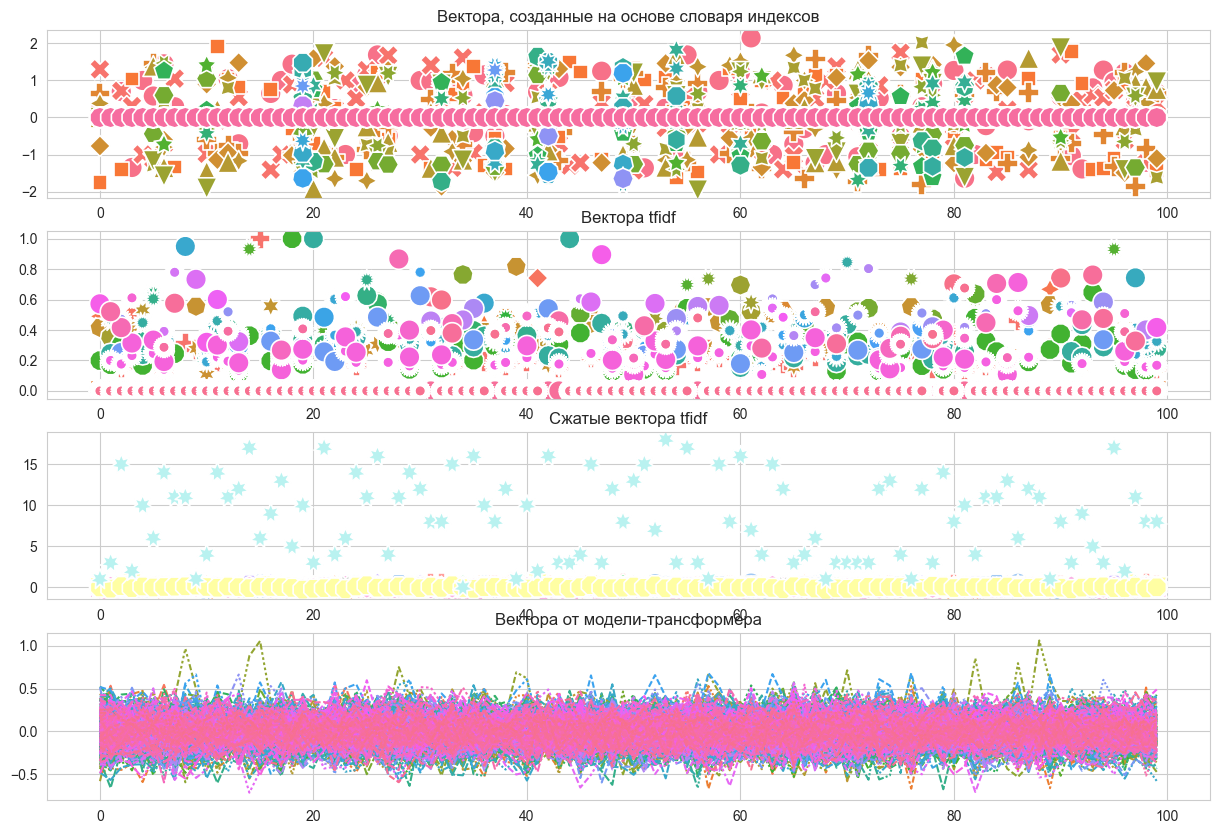

In [89]:
plt.figure(figsize = (15, 10))
plt.subplot(411)
sns.scatterplot(vect_text[:100], legend=False)
plt.title('Вектора, созданные на основе словаря индексов')
plt.subplot(412)
sns.scatterplot(tfidf_vectors_all_df[:100], legend=False)
plt.title('Вектора tfidf')
plt.subplot(413)
sns.scatterplot(pca19D_df[:100], legend=False)
plt.title('Сжатые вектора tfidf')
plt.subplot(414)
sns.lineplot(embs_df[:100], legend=False)
plt.title('Вектора от модели-трансформера')
plt.show()

- итого лучшие метрики дают эмбеддинги от модели трансформера, также я создала новый признак для финального датасета это косинусное сходство между эмбеддингами тегов и комментариев
- также интересно посмотреть на визуализацию векторов, полученных разными способами: видим что только вектора из словаря индексов имеют отрицательные значения, соотвественно с их нормализацией распределены вокруг ноля, структура сжатых векторов от tfidf повторяет схему распределения их же в нормальном состоянии, а вот эмбеддинги трансформера обладают самой плотной структурой, равномерно распределенной вокруг единицы, но мы можем заметить и имеющиеся немногочисленные выбросы
- теперь разделю датасет на тренировочную и валидационную часть

In [90]:
#предобработка
X = pd.concat([train[['assessment', 'assortment', 'catalog_navigation', 'delivery', 'payment', 'price',
       'products_quality', 'promotions', 'support', 'neutral', 'negative', 'positive', 'lev_dis',
       'reg_preds', 'clf_preds', 'cos_sim']].reset_index(drop=True),emb_comm_df, emb_tag_df], axis=1)
y = np.asarray(train[targets])
X.columns = X.columns.astype(str)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)

- итого произведя анализ имеющихся текстов, на его основании были созданы новые признаки для финального датасета:
  - отдельные эмбеддинги для комментариев и тегов, полученные от модели-трансформера
  - столбцы с количественными характеристиками эмоциональной окраски комментариев
  - столбец с расстоянием Левинштейнв между текстами и основными тегами
  - предсказания оценки пользователя на основании имеющихся векторов от модели регрессора и классификатора
  - косинусное сходство между эмбеддингами комментариев и тегов

***4. Валидация моделей***

- так как мы имеем дело с задачей многозадачной классификации валидацию я буду проводить при помощи таких множественных алгоритмов вывода как: LabelPowerset, ClassifierChain, BinaryRelevance, в качестве классификаторов буду использовать LogisticRegression, XGBClassifier. CatBoostClassifier дает результаты сравнымые с XGBClassifier, но время обучения практически в 3 раза больше, поэтому я не стала оставлять его в тетрадке.

In [91]:
clf = LabelPowerset(LogisticRegression(random_state=random_state)).fit(X_train, y_train)
print('Accuracy:', accuracy_score(y_val, clf.predict(X_val)), 'hamming_loss:',
hamming_loss(y_val, clf.predict(X_val)))

Accuracy: 0.5063145809414467 hamming_loss: 0.01653272101033295


In [92]:
clf_cc = ClassifierChain(XGBClassifier(random_state=random_state)).fit(X_train, y_train)
print('Accuracy:', accuracy_score(y_val, clf_cc.predict(X_val)), 'hamming_loss:',
hamming_loss(y_val, clf_cc.predict(X_val)))

Accuracy: 0.6107921928817451 hamming_loss: 0.011848450057405282


In [93]:
classifier = BinaryRelevance(XGBClassifier(random_state=random_state))# train
classifier.fit(X_train, y_train)# predict
predictions = classifier.predict(X_val)# accuracy
print("Accuracy = ",accuracy_score(y_val,predictions))
br_preds = clf.predict(X_val)

Accuracy =  0.6096440872560276


In [94]:
clf = LabelPowerset(XGBClassifier(random_state=random_state)).fit(X_train, y_train)
print('Accuracy:', accuracy_score(y_val, clf.predict(X_val)), 'hamming_loss:',
hamming_loss(y_val, clf.predict(X_val)))
lb_preds = clf.predict(X_val)

Accuracy: 0.6285878300803674 hamming_loss: 0.0151894374282434


- как видно лучшую метрику дал LabelPowerset с эстиматором XGBClassifier

***5. Тестирование лучшей модели***

In [95]:
try:
    test = pd.read_csv\
        ('/Users/maiiayakusheva/Downloads/nlp-user-experience-multilabel-classification/test.csv')
except:
    test = pd.read_csv('/nlp-user-experience-multilabel-classification/test.csv')
test = test.fillna('0')

In [96]:
tags_list = np.unique(pd.Series([re.sub('[{}]', '', x) for x in test.tags])\
    .str.split(',', expand=True).dropna().values).tolist()
def tags(name):
    test[name.lower()]=pd.Series(np.where(test.tags.str.contains(pat=name)==True, 1, 0))
for x in tags_list:
    tags(x)

In [97]:
res = model.predict(test.text.tolist(), k=2)
sentiment_list = []
for sentiment in res:
    sentiment_list.append(sentiment)

neutral_list = []
negative_list = []
positive_list = []
speech_list = []
skip_list = []
for sentiment in sentiment_list:
    neutral = sentiment.get('neutral')
    negative = sentiment.get('negative')
    positive = sentiment.get('positive')
    if neutral is None:
        neutral_list.append(0)
    else:
        neutral_list.append(sentiment.get('neutral'))
    if negative is None:
        negative_list.append(0)
    else:
        negative_list.append(sentiment.get('negative'))
    if positive is None:
        positive_list.append(0)
    else:
        positive_list.append(sentiment.get('positive'))
test['neutral'] = neutral_list
test['negative'] = negative_list
test['positive'] = positive_list

In [98]:
test['prepr_text'] = preprocess_text(test.text)

In [99]:
for x in tags_rus:
    lev_dis = []
    lev_dis.append(sim_metrics(edit_distance, test.prepr_text, x))

test['lev_dis'] = np.array(lev_dis).reshape(-1).tolist()

In [101]:
test['tags'] = [re.sub('[{}]', '', x) for x in test.tags.str.lower()]
test['tags'] = [re.sub(',', ', ', x) for x in test.tags]
def elem_func(w1, w2):
    l = [re.sub(w1, w2, x) for x in test.tags]
    return l
def new_test_col(tag1, tag2):
    test['tags'] = elem_func(tag1, tag2)

new_test_col('assortment', 'ассортимент')
new_test_col('promotions', 'акции')
new_test_col('delivery', 'доставка')
new_test_col('price', 'цена')
new_test_col('products_quality', 'качество')
new_test_col('catalog_navigation', 'каталог')
new_test_col('payment', 'платеж')
new_test_col('support', 'поддержка')

In [103]:
emb_comm = model1.encode(test.text)
emb_comm_df_test = pd.DataFrame(emb_comm)
emb_tag = model1.encode(test.tags)
emb_tag_df_test = pd.DataFrame(emb_tag)

In [104]:
for x in emb_tag:
    sim=util.cos_sim(emb_comm, [x])
test['cos_sim'] = sim

In [105]:
all_text = test[['prepr_text', 'tags']].agg(', '. join , axis= 1)
embeddings = model1.encode(all_text)
embs_df = pd.DataFrame(embeddings)

In [106]:
test.assessment = test.assessment.astype('int')

In [109]:
reg_preds = lgbm_reg.predict(embs_df)
test['reg_preds'] = reg_preds
clf_preds = lgbm_clf.predict(embs_df)
test['clf_preds'] = clf_preds

In [111]:
X_test = pd.concat([test[['assessment', 'assortment', 'catalog_navigation', 'delivery', 'payment', 'price',
       'products_quality', 'promotions', 'support', 'neutral', 'negative', 'positive', 'lev_dis',
       'reg_preds', 'clf_preds', 'cos_sim']].reset_index(drop=True), emb_comm_df_test,\
         emb_tag_df_test], axis=1)
X_test.columns = X_test.columns.astype(str)

In [112]:
clf = LabelPowerset(XGBClassifier(random_state=random_state)).fit(X, y)
preds = clf.predict(X_test).toarray()
predictions = pd.DataFrame(np.hstack([test["index"].values.reshape(test.shape[0], 1), preds]),
                  columns = ["index"]+[f"trend_id_res{i}" for i in range(50)])

,index,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
3203,23421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1569,21661,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16599,26246,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5338,12565,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9587,8605,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6328,12635,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
predictions.head()

,index,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,5905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3135,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9285,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4655,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16778,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [931]:
#predictions.to_csv('/Users/maiiayakusheva/Desktop/проект/preds.csv', index=False)

- проверка на тестовом датасете на платформе каggle дала целевую метрику 0.6388, что превышает метрику валидации.

***6. Итогововые выводы по проекту:***
- в трейновом датасете изначально было открыто 8708строк и 54 столбца с данными, данные были проверены на дубликаты и пропуски
- в ходе предварительного анализа данных было выявлено:
  - столбец "assessment" несет в себе информацию об оценках сервиса пользователями. По информации от заказчика тут нет самых высоких оченок (шкала о  1 до 10), соотвественно высшей оценкой является значение 6. По распределению видно, что практически половину(45.2%) от всех оценок занимает значение 5
  - далее из столбца с тегами, который несет информацию о том, чем именно в сервисе недоволен потребитель, я выделили бинарные столбцы (8 шт) для каждого тега и проставлю в них единицы там, где этот тег соотвественно упоминается 
  - было выявлено, что меньше всего недовольства вызывает система платежей и навигация по катологу, а вот больше всего - доставка, выбор продукции и промоушен (это три тега где количество наличия недовольных тегов превышает количество их отсутствия)
  - можно заметить, что пользователи, поставившие низшую оценку (0), более всего недовольны доставкой, в то время как пользователи с наивысшей из имеющихся оценкой - ассортиментом продукции
  - по распределению таргетов видно, что наибольшее количество положительного класса присутствует у значений: "Долгая доставка",  "Высокие цены", "Несоотвествие времени доставки" (что в принципе соотвествует распределению тегов)
  - при первичном анализе комментариев было выявлено, что большинство занимют положительные комментарии и жалобы на доставку
- далее в разделе Анализ данных, сочетавший в себе также их предобработку и создание новых признаков:
  - при помощи библиотеки dostoevsky я проанализировала семантику комментариев и создала три столбца с сентиментарными характеристиками комментариев (позитивные/негативные/нейтральные)
  - далее я провела предобработку текстов: привела в нижний регистр, убрала знаки пунктуации, символы,стоп-слова, токенизировала и лематизировала текст.
  - затем вывела средние/максимальные/минимальные(для расстояния) метрики близости (расстояние Левинштейна,Джаро) комментариев и тегов, переведенных на русский(я не стала подтягивать переводчик, их всего восемь штук))
  - создала на этих метриках доп признаки (в итоговом датасете оставила расстояние Левинштейна)
  - ввела признак с длиной каждого комментария
  - потом перевела теги на русский через регулярки, так как эта манипуляция через например айпи гугл транса занимает более получаса) Затем добавила переведенные теги к нашим текстам, посмотрев на изменение целевой метрики,  и поэксперементировала со снижением размерности
  - итого лучшие метрики дают эмбеддинги от модели трансформера, также я создала новый признак для финального датасета это косинусное сходство между эмбеддингами тегов и комментариев
  - также интересно посмотреть на визуализацию векторов, полученных разными способами: видим что только вектора из словаря индексов имеют отрицательные значения, соотвественно с их нормализацией распределены вокруг ноля, структура сжатых векторов от tfidf повторяет схему распределения их же в нормальном состоянии, а вот эмбеддинги трансформера обладают самой плотной структурой, равномерно распределенной вокруг единицы, но мы можем заметить и имеющиеся немногочисленные выбросы
  - затем разделила тренировочный датасет на тренировочную и валидационную часть
  - итого произведя анализ имеющихся текстов, на его основании были созданы новые признаки для финального датасета:
    - отдельные эмбеддинги для комментариев и тегов, полученные от модели-трансформера
    - столбцы с количественными характеристиками эмоциональной окраски комментариев
    - столбец с расстоянием Левинштейнв между текстами и основными тегами
    - предсказания оценки пользователя на основании имеющихся векторов от модели регрессора и классификатора
    - косинусное сходство между эмбеддингами комментариев и тегов
- затем в разделе с валидацией моделей так как мы имеем дело с задачей многозадачной классификации валидацию я проводила при помощи таких множественных алгоритмов вывода как: LabelPowerset, ClassifierChain, BinaryRelevance, в качестве классификаторов буду использовать LogisticRegression, XGBClassifier. CatBoostClassifier дает результаты сравнымые с XGBClassifier, но время обучения практически в 3 раза больше, поэтому я не стала оставлять его в тетрадке
- и в итоге проверка на тестовом датасете на платформе каggle дала целевую метрику 0.6388, что превышает метрику валидации